In [1]:
import torch
from torch import nn
from torchvision import models
from torchvision import transforms
from torch import optim
from PIL import Image
import os
import torch.nn as nn
from torch.autograd import Variable

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
data = pd.read_pickle("dataframe.pkl")
data.head()

,folder,image,Emotion,Labels
0,./KDEF_and_AKDEF/sorted_set/sadness,AF34SAHR.JPG,sadness,5
1,./KDEF_and_AKDEF/sorted_set/neutral,AM25NEHL.JPG,neutral,4
2,./KDEF_and_AKDEF/sorted_set/fear,AM07AFFL.JPG,fear,2
3,./KDEF_and_AKDEF/sorted_set/sadness,BF16SAHL.JPG,sadness,5
4,./KDEF_and_AKDEF/sorted_set/surprise,AF35SUHL.JPG,surprise,6


In [5]:
num_classes = 7

In [6]:
data_train, data_test = train_test_split(data, stratify=data["Labels"], test_size = 0.2, random_state=1)
data_train, data_cv = train_test_split(data_train, stratify=data_train["Labels"], test_size = 0.2, random_state=1)
data_train.shape, data_cv.shape, data_test.shape

((3134, 4), (784, 4), (980, 4))

In [7]:
# data_train=data_train[:320]
# data_cv = data_cv[:70]
# data_train.shape, data_cv.shape

In [8]:
class new_model(nn.Module):
    def __init__(self):
        super(new_model, self).__init__()
        self.features = nn.Sequential(*list(vgg.features.children()))
        input_dim = 10*10*512
        self.fc1 = nn.Sequential(nn.Linear(input_dim, 512), nn.ReLU(), nn.Dropout(0.5))
        self.fc2 = nn.Sequential(nn.Linear(512, 256), nn.ReLU(), nn.BatchNorm1d(256), nn.Dropout(0.5))
        self.fc3 = nn.Sequential(nn.Linear(256, 128), nn.ReLU(), nn.BatchNorm1d(128), nn.Dropout(0.5))
        self.fc4 = nn.Sequential(nn.Linear(128, 64), nn.ReLU(), nn.BatchNorm1d(64), nn.Dropout(0.5))
        self.fc5 = nn.Sequential(nn.Linear(64, num_classes))
        
    def forward(self, x):
        out = self.features(x)
        out = out.reshape(out.shape[0], -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        out = self.fc5(out)
        return out

In [9]:
train_labels = np.array(data_train["Labels"])
test_labels = np.array(data_test["Labels"])
cv_labels = np.array(data_cv["Labels"])

In [10]:
def get_batch_Train(batch_size):
    global pointer_train
    images_batch = []
    labels_batch = []
    for i in range(batch_size):
        path1 = data_train.iloc[pointer_train + i]["folder"]
        path2 = data_train.iloc[pointer_train + i]["image"]
        image = Image.open(os.path.join(path1, path2))
        image=np.array(image).transpose(2,0,1)
        image_norm = image/255.0
        images_batch.append(image_norm)
        
        labels_batch.append(train_labels[pointer_train + i])
        
    pointer_train += batch_size
        
    return np.array(images_batch), np.array(labels_batch)

In [11]:
def get_batch_Test(batch_size):
    global pointer_test
    images_batch = []
    labels_batch = []
    for i in range(batch_size):
        path1 = data_test.iloc[pointer_test + i]["folder"]
        path2 = data_test.iloc[pointer_test + i]["image"]
        image = Image.open(os.path.join(path1, path2))
        image=np.array(image).transpose(2,0,1)
        image_norm = image/255.0
        images_batch.append(image_norm)
        
        labels_batch.append(test_labels[pointer_test + i])
        
    pointer_test += batch_size
        
    return np.array(images_batch), np.array(labels_batch)

In [12]:
def get_batch_cv(batch_size):
    global pointer_cv
    images_batch = []
    labels_batch = []
    for i in range(batch_size):
        path1 = data_cv.iloc[pointer_cv + i]["folder"]
        path2 = data_cv.iloc[pointer_cv + i]["image"]
        image = Image.open(os.path.join(path1, path2))
        image=np.array(image).transpose(2,0,1)
        image_norm = image/255.0
        images_batch.append(image_norm)
        
        labels_batch.append(cv_labels[pointer_cv + i])
        
    pointer_cv += batch_size
        
    return np.array(images_batch), np.array(labels_batch)

In [19]:
def train (input_image,target):
    FEN.train()
    optimizer.zero_grad()
    prob=FEN(input_image)
    loss=criterion(prob,target)
    loss.backward()
    optimizer.step()
    return loss.item()

In [20]:
def validate (input_image,target):
    with torch.no_grad():
        FEN.eval()
        prob=FEN(input_image)
        loss=criterion(prob,target)
        return loss.item()

In [26]:
vgg = models.vgg16(pretrained=True).to(device)
FEN = new_model().to(device)
for param in FEN.features.parameters():
    param.requires_grad = False

In [27]:
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(FEN.parameters())
optimizer = torch.optim.Adam(
    [
        {"params": FEN.features.parameters(), "lr": 1e-5},
        {"params": FEN.fc1.parameters()},
        {"params": FEN.fc2.parameters()},
        {"params": FEN.fc3.parameters()},
        {"params": FEN.fc4.parameters()},
        {"params": FEN.fc5.parameters()},
    ],
    lr=1e-3,
)

In [28]:
train_loss=[]
validation_loss=[]
epochs = 30
batch_size = 16
global_loss=1.0
train_images = int(len(data_train) / batch_size)
cv_images = int(len(data_cv) / batch_size)
for epoch in range(epochs):
    if epoch == 10:
        for p in FEN.parameters():
            p.requires_grad = True
    pointer_train = 0
    pointer_test = 0
    pointer_cv = 0

    running_loss = 0
#     if (epoch+1)%10 == 0:
#         for g in optimizer.param_groups:
#             g['lr']/=2
    for i in range(train_images):
        X_train, y_train = get_batch_Train(batch_size)
        X_train = Variable(torch.tensor(X_train)).to(device).float()
        y_train = Variable(torch.tensor(y_train)).to(device)
        loss=train(X_train,y_train)
        running_loss+=loss
    #Validation
    loss_val=0
    for j in range(cv_images):
        X_cv, y_cv = get_batch_cv(batch_size)
        X_cv = Variable(torch.tensor(X_cv)).to(device).float()
        y_cv = Variable(torch.tensor(y_cv)).to(device)
        loss_val+=validate(X_cv,y_cv)
    loss_val=loss_val/(j+1)
    validation_loss.append(loss_val)
    running_loss = running_loss/(i+1)
    train_loss.append(running_loss)
    print ('Epoch: {} | Training loss: {} | Validation Loss: {}'.format(epoch+1, running_loss, loss_val))
    if(global_loss > loss_val):
        global_loss = loss_val
        torch.save(FEN.state_dict(), './saved_models/VGG-Adam-LR-3-5.pth')
        print("Model saved at epoch: {}".format(epoch+1))
                   
    #print ('Epoch: {} | Training loss: {}'.format(epoch+1, running_loss))

    

Epoch: 1 | Training loss: 1.9960447776011931 | Validation Loss: 1.9051946596223481
Epoch: 2 | Training loss: 1.9403807419996995 | Validation Loss: 1.857482143810817
Epoch: 3 | Training loss: 1.8638748486836751 | Validation Loss: 1.7352257188485594
Epoch: 4 | Training loss: 1.7740237034284152 | Validation Loss: 1.610587450922752
Epoch: 5 | Training loss: 1.6293433562303201 | Validation Loss: 1.4875479036447954
Epoch: 6 | Training loss: 1.5309797170834663 | Validation Loss: 1.416895190063788
Epoch: 7 | Training loss: 1.4070932675630619 | Validation Loss: 1.3106761903178936
Epoch: 8 | Training loss: 1.2829924565095168 | Validation Loss: 1.2019180485180445
Epoch: 9 | Training loss: 1.181485197482965 | Validation Loss: 1.1361247970133412
Epoch: 10 | Training loss: 1.121607236067454 | Validation Loss: 1.1392931488095497
Epoch: 11 | Training loss: 1.0343154473182483 | Validation Loss: 1.0484175231991981
Epoch: 12 | Training loss: 0.9070298228508387 | Validation Loss: 1.0220916222552865
Epoch:

In [46]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
def print_confusionMatrix(Y_TestLabels, PredictedLabels):
    confusionMatx = confusion_matrix(Y_TestLabels, PredictedLabels)
    
    precision = confusionMatx/confusionMatx.sum(axis = 0)
    
    recall = (confusionMatx.T/confusionMatx.sum(axis = 1)).T
    
    sns.set(font_scale=1.5)
    
    
    labels = ["ANGRY", "DISGUST", "FEAR", "HAPPY", "NEUTRAL", "SAD", "SURPRISE"]
    
    plt.figure(figsize=(16,7))
    sns.heatmap(confusionMatx, cmap = "Blues", annot = True, fmt = ".1f", xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.xticks(rotation = 90)
    plt.show()
    
    plt.figure(figsize=(16,7))
    sns.heatmap(precision, cmap = "Blues", annot = True, fmt = ".2f", xticklabels=labels, yticklabels=labels)
    plt.title("Precision Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.xticks(rotation = 90)
    plt.show()
    
    
    plt.figure(figsize=(16,7))
    sns.heatmap(recall, cmap = "Blues", annot = True, fmt = ".2f", xticklabels=labels, yticklabels=labels)
    plt.title("Recall Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.xticks(rotation = 90)
    plt.show()

In [30]:
FEN.load_state_dict(torch.load('./saved_models/VGG-Adam-LR-3-5.pth'))
FEN.eval()

new_model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): 

In [44]:
test_images = len(data_test)
predicted_labels=[]
true_labels=[]
pointer_test = 0
for i in range(test_images):
    X_test, y_test = get_batch_Test(1)
    
    X_test = Variable(torch.tensor(X_test)).to(device).float()
    X_test.unsqueeze(0)
    pred=FEN(X_test)
    predicted_labels.append(pred.argmax().item())
    true_labels.append(y_test[0])
acc = accuracy_score(true_labels, predicted_labels)
print("Accuracy on Human Test Data = {}%".format(np.round(float(acc*100), 2)))

Accuracy on Human Test Data = 76.33%


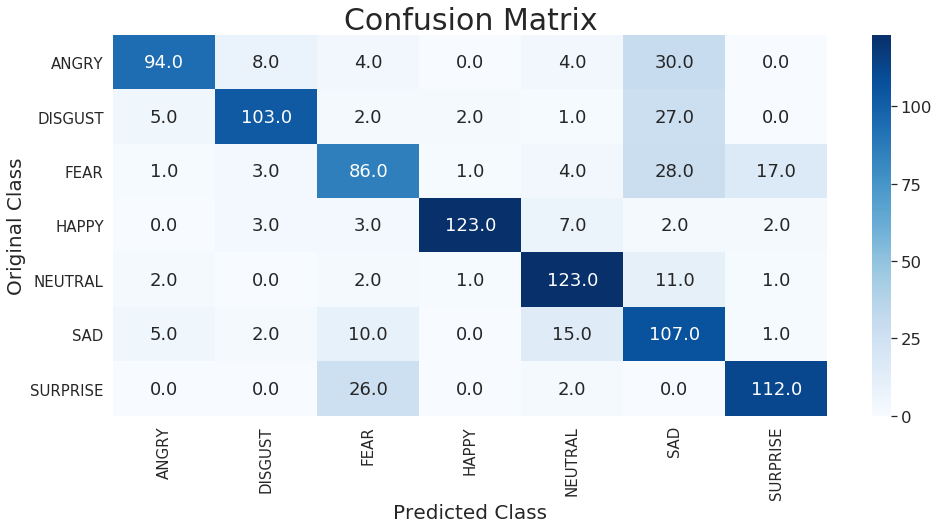

-----------------------------------------------------------------------------------------------------------------------------


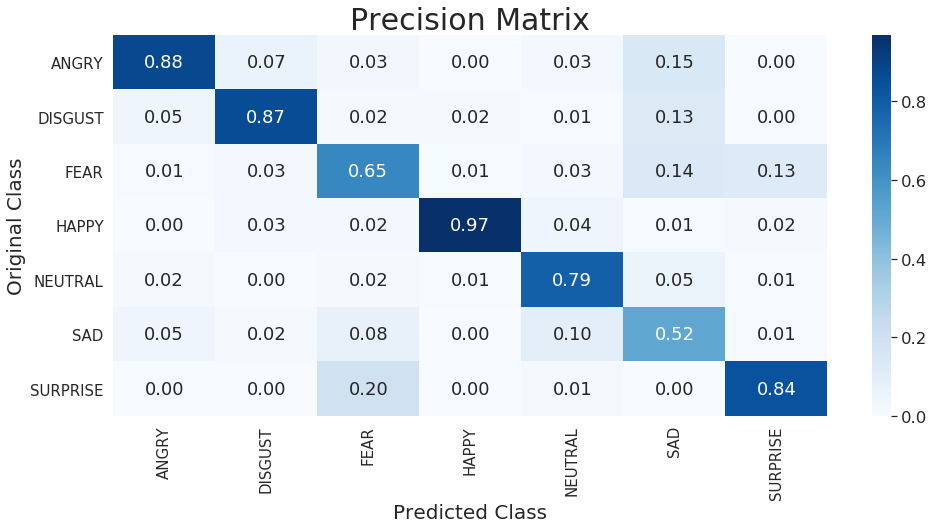

-----------------------------------------------------------------------------------------------------------------------------


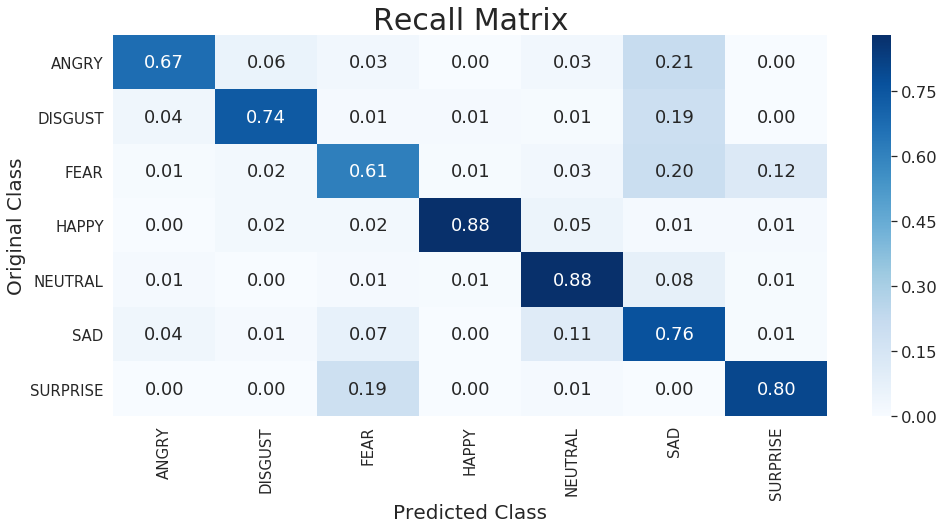

In [47]:
print_confusionMatrix(true_labels, predicted_labels)

In [73]:
emotions = {1:"ANGRY", 2:"DISGUST", 3:"FEAR", 4:"HAPPY", 5:"NEUTRAL", 6:"SAD", 7:"SURPRISE"}
def pridict_real_image(img_path):
    image = Image.open(img_path)
    image=np.array(image).transpose(2,0,1)
    image_norm = image/255.0
    X_test = Variable(torch.tensor(image_norm)).to(device).float()
    X_test = X_test.unsqueeze(0)
    pred=FEN(X_test)
    label = pred.argmax().item() + 1
    print("Predicted Facial Expression Probabilities")
    print("ANGRY: {}\nDISGUST: {}\nFEAR: {}\nHAPPY: {}\nNEUTRAL: {}\nSAD: {}\nSURPRISE: {}\n\n".format(pred[0][0].item(), pred[0][1].item(), pred[0][2].item(),pred[0][3].item(), pred[0][4].item(), pred[0][5].item(), pred[0][6].item()))
    print("Dominant Probability = "+str(emotions[label]))
    

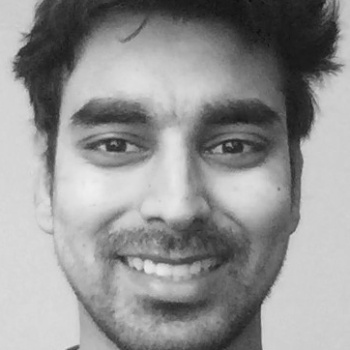

In [74]:
Image.open('happy.jpg')

In [75]:
pridict_real_image('happy.jpg')

Predicted Facial Expression Probabilities
ANGRY: -1.902876853942871
DISGUST: 0.06312862038612366
FEAR: 1.2709579467773438
HAPPY: 3.2420363426208496
NEUTRAL: 1.048706293106079
SAD: -0.44199854135513306
SURPRISE: -1.626534104347229


Dominant Probability = HAPPY


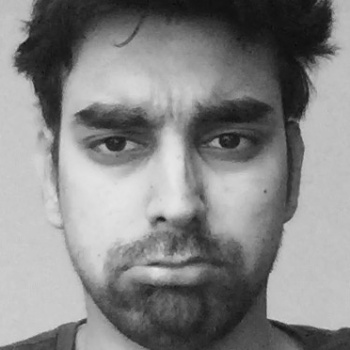

In [76]:
Image.open('sad.jpg')

In [77]:
pridict_real_image('sad.jpg')

Predicted Facial Expression Probabilities
ANGRY: 3.4947030544281006
DISGUST: -1.052270531654358
FEAR: -1.2545313835144043
HAPPY: -3.9803638458251953
NEUTRAL: 0.4889746606349945
SAD: 3.7064707279205322
SURPRISE: -3.2392890453338623


Dominant Probability = SAD


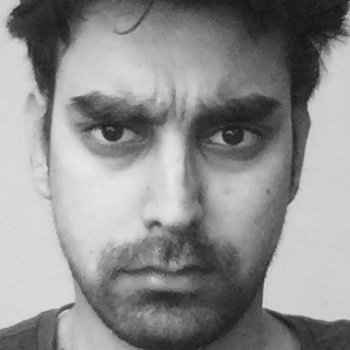

In [78]:
Image.open('angry.jpg')

In [79]:
pridict_real_image('angry.jpg')

Predicted Facial Expression Probabilities
ANGRY: 5.461879730224609
DISGUST: -0.12989908456802368
FEAR: -2.2789254188537598
HAPPY: -3.821579694747925
NEUTRAL: -0.2405034303665161
SAD: 2.8347082138061523
SURPRISE: -3.6507222652435303


Dominant Probability = ANGRY


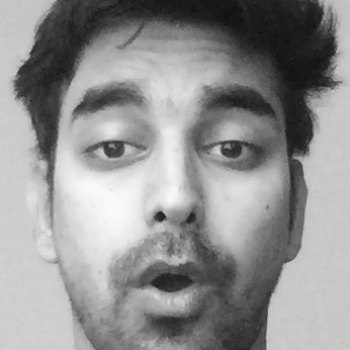

In [80]:
Image.open('surprise.jpg')

In [81]:
pridict_real_image('surprise.jpg')

Predicted Facial Expression Probabilities
ANGRY: -2.4361987113952637
DISGUST: -2.8146560192108154
FEAR: 4.2528557777404785
HAPPY: -1.2559210062026978
NEUTRAL: -0.573086142539978
SAD: -0.6917433142662048
SURPRISE: 4.72913932800293


Dominant Probability = SURPRISE


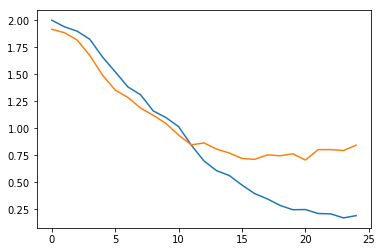

In [80]:
# VGG16 - LR- 1e-5, rest - LR - 1e-3, Adam
import matplotlib.pyplot as plt
plt.plot(np.arange(0, 25), train_loss)
plt.plot(np.arange(0, 25), validation_loss)

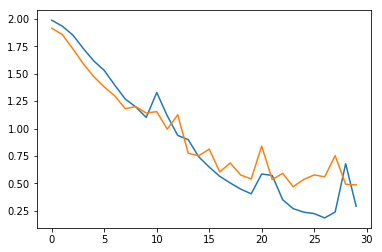

In [84]:
# VGG16 - LR- 1e-4, rest - LR - 1e-3, Adam
import matplotlib.pyplot as plt
plt.plot(np.arange(0, epochs), train_loss)
plt.plot(np.arange(0, epochs), validation_loss)

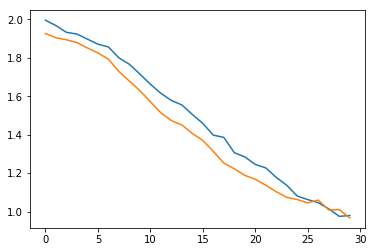

In [91]:
# VGG16 - LR- 1e-5, rest - LR - 1e-2, SGD
import matplotlib.pyplot as plt
plt.plot(np.arange(0, epochs), train_loss)
plt.plot(np.arange(0, epochs), validation_loss)

In [111]:
class Resnet_model(nn.Module):
    def __init__(self):
        super(Resnet_model, self).__init__()
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        input_dim = 5*5*512
        self.fc1 = nn.Sequential(nn.Linear(input_dim, 512), nn.ReLU(), nn.Dropout(0.5))
        self.fc2 = nn.Sequential(nn.Linear(512, 256), nn.ReLU(), nn.BatchNorm1d(256), nn.Dropout(0.5))
        self.fc3 = nn.Sequential(nn.Linear(256, 128), nn.ReLU(), nn.BatchNorm1d(128), nn.Dropout(0.5))
        self.fc4 = nn.Sequential(nn.Linear(128, 64), nn.ReLU(), nn.BatchNorm1d(64), nn.Dropout(0.5))
        self.fc5 = nn.Sequential(nn.Linear(64, num_classes))
        
    def forward(self, x):
        out = self.features(x)
        out = out.reshape(out.shape[0], -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        out = self.fc5(out)
        return out

In [118]:
resnet = models.resnet34(pretrained=True).to(device)
FEN_resnet = Resnet_model().to(device)
for param in FEN_resnet.features.parameters():
    param.requires_grad = False

In [119]:
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(FEN.parameters())
optimizer = torch.optim.Adam(
    [
        {"params": FEN_resnet.features.parameters(), "lr": 1e-4},
        {"params": FEN_resnet.fc1.parameters()},
        {"params": FEN_resnet.fc2.parameters()},
        {"params": FEN_resnet.fc3.parameters()},
        {"params": FEN_resnet.fc4.parameters()},
        {"params": FEN_resnet.fc5.parameters()},
    ],
    lr=1e-2,
)

In [ ]:
train_loss=[]
validation_loss=[]
epochs = 30
batch_size = 16
train_images = int(len(data_train) / batch_size)
cv_images = int(len(data_cv) / batch_size)
for epoch in range(epochs):
    if epoch == 10:
        for p in FEN_resnet.parameters():
            p.requires_grad = True
    pointer_train = 0
    pointer_test = 0
    pointer_cv = 0

    running_loss = 0
#     if (epoch+1)%10 == 0:
#         for g in optimizer.param_groups:
#             g['lr']/=2
    for i in range(train_images):
        X_train, y_train = get_batch_Train(batch_size)
        X_train = Variable(torch.tensor(X_train)).to(device).float()
        y_train = Variable(torch.tensor(y_train)).to(device)
        
        loss=train(X_train,y_train)
        running_loss+=loss
    #Validation
    loss_val=0
    for j in range(cv_images):
        X_cv, y_cv = get_batch_cv(batch_size)
        X_cv = Variable(torch.tensor(X_cv)).to(device).float()
        y_cv = Variable(torch.tensor(y_cv)).to(device)
        loss_val+=validate(X_cv,y_cv)
    loss_val=loss_val/(j+1)
    validation_loss.append(loss_val)
    running_loss = running_loss/(i+1)
    train_loss.append(running_loss)
    print ('Epoch: {} | Training loss: {} | Validation Loss: {}'.format(epoch+1, running_loss, loss_val))
    #print ('Epoch: {} | Training loss: {}'.format(epoch+1, running_loss))

Epoch: 1 | Training loss: 1.9994503724269377 | Validation Loss: 1.9443624360220773
Epoch: 2 | Training loss: 1.963759852678348 | Validation Loss: 1.9426420878390878
Epoch: 3 | Training loss: 1.953816430996626 | Validation Loss: 1.9342058118508787
Epoch: 4 | Training loss: 1.95437149756994 | Validation Loss: 1.9396368630078373
Epoch: 5 | Training loss: 1.9415655435659946 | Validation Loss: 1.9005563380766888
Epoch: 6 | Training loss: 1.912474921422127 | Validation Loss: 1.8332884603617143
Epoch: 7 | Training loss: 1.8787417833621685 | Validation Loss: 1.810152783685801
Epoch: 8 | Training loss: 1.841494876299149 | Validation Loss: 1.7635050549799083
Epoch: 9 | Training loss: 1.827117580633897 | Validation Loss: 1.7571695994357674
Epoch: 10 | Training loss: 1.8176245634372419 | Validation Loss: 1.7336624690464564
Epoch: 11 | Training loss: 1.6649199473552214 | Validation Loss: 1.4119039725284188
Epoch: 12 | Training loss: 1.430994851161272 | Validation Loss: 1.484405237801221
Epoch: 13 |